In [1]:
import sys
sys.path.append('./M1')         # for model.py
sys.path.append('./M3/S_TLLR')  # for models/, utils/, etc.

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tonic
import tonic.transforms as TT
from torch.utils.data import DataLoader
import argparse

from model import PleiadesClassifier
from models.VGG_STDP import dvs_vgg_stllr
from utils.setup import setup
from utils.train import data_resizing

/opt/anaconda-2024.02/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/anaconda-2024.02/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## M1

### Setup

In [3]:
m1_transform = TT.Compose([
    TT.CropTime(max=1500000 - 1),
    TT.ToFrame(sensor_size=tonic.datasets.DVSGesture.sensor_size, time_window=10000, include_incomplete=True)
])

m1_dataset = tonic.datasets.DVSGesture(save_to='./M1/Dataset', train=False, transform=m1_transform)
m1_loader = DataLoader(m1_dataset, batch_size=8, drop_last=False)

m1_net = PleiadesClassifier(
    in_channels=2,
    num_classes=10,
    channels=[8, 16, 32, 48, 64, 80, 96, 112, 128, 256],
    features=256,
    depthwises=[False, False, True, True, True],
    kernel_size=(3, 3, 10),
    stride=(2, 2, 1),
    padding=(1, 1, 0),
)
m1_net.load_state_dict(torch.load('./M1/dvs128_ckpt.pt'))
m1_net.eval().cuda()

m1_offset = 44

print("Loaded Method 1 model")

Loaded Method 1 model


### Inference

In [4]:
print("Running latency vs accuracy for M1...")
m1_preds_all = []
m1_labels_all = []

with torch.no_grad():
    for events, labels in m1_loader:
        events = events.float().cuda().moveaxis(1, -1)
        events = F.pad(events, (m1_offset, 0))
        output = m1_net(events)  # shape: (B, C, T)
        preds = output.argmax(1).cpu()
        m1_preds_all.append(preds)
        m1_labels_all.append(labels)

m1_preds_all = torch.cat(m1_preds_all)  # shape (N, T)
m1_labels_all = torch.cat(m1_labels_all)

mask = (m1_labels_all != 10)
m1_preds_all = m1_preds_all[mask]
m1_labels_all = m1_labels_all[mask]

# M1 Latency vs Accuracy
m1_accuracies = []
for t in range(m1_preds_all.shape[1]):
    if t <= m1_offset:
        pred = m1_preds_all[:, t]
    else:
        pred = m1_preds_all[:, m1_offset:].mode(dim=1)[0]
    acc = (pred == m1_labels_all).float().mean().item()
    m1_accuracies.append(acc)

m1_latencies_ms = np.arange(len(m1_accuracies)) * 10
m1_final_acc = max(m1_accuracies)

print("Done!")

Running latency vs accuracy for M1...
Done!


## M2

### Setup

In [6]:
args = argparse.Namespace(
    dataset='DVSGesture',
    arch='dvs_vgg_stllr',
    data_path='./M3/S_TLLR/Dataset',
    save_path='./M3/S_TLLR/experiments/VGG_Gesture_STLLR',
    batch_size=16,
    val_batch_size=64,
    label_encoding='class',
    classif=True,
    delay_ls=5,
    n_classes=11,
    n_inputs=2,
    dt=75e-3,
    n_steps=20,
    training_mode='stllr',
    cuda=True,
    cpu=False,
    feedback_mode='BP',
    scheduler=0,
    weight_decay=0,
    seed=1234,
    loss='CE',
    activation='LinearSpike',
    factors_stdp=[0.2, 0.75, -1, 1],
    pooling='MAX',
    pretrained_model=None
)

device, _, test_loader = setup(args)

m2_model = dvs_vgg_stllr(args, device)
ckpt = torch.load('./M3/S_TLLR/experiments/VGG_Gesture_STLLR/t2/trial_1_model_final.pth.tar')
m2_model.load_state_dict(ckpt['state_dict'])
m2_model.eval().cuda()

print("Loaded 2nd model")

Metadata read from ./M3/S_TLLR/Dataset/metadata/online_dvsg_train/slice_metadata.h5.
Went from 1077 samples in the original dataset to 3871 in the sliced version.
Went from 264 samples in the original dataset to 264 in the sliced version.
Loaded 2nd model


### Inference

In [7]:
print("Running latency vs accuracy for M2...")

m2_latencies_ms = []
m2_accuracies = []

for max_t in range(1, args.n_steps + 1):
    preds_list, labels_list = [], []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.float().to(device), label.to(device)
            data, label, target, timesteps = data_resizing(args, data, label, device)

            m2_model.reset_states()
            pred = 0
            for t in range(max_t):
                input_t = data[t] if data.size(0) > 1 else data[0]
                output_t = m2_model(input_t, None)
                pred += output_t

            final_pred = pred.argmax(dim=1)
            preds_list.append(final_pred.cpu())
            labels_list.append(label.cpu())

    preds = torch.cat(preds_list)
    labels = torch.cat(labels_list)
    mask = (labels != 10)
    preds = preds[mask]
    labels = labels[mask]

    acc = (preds == labels).float().mean().item()
    m2_latencies_ms.append(max_t * args.dt * 1000)
    m2_accuracies.append(acc)

    print(f"{int(m2_latencies_ms[-1])} ms: Accuracy = {acc * 100:.2f}%")

m2_final_acc = max(m2_accuracies)

Running latency vs accuracy for M2...
75 ms: Accuracy = 48.75%
150 ms: Accuracy = 56.25%
224 ms: Accuracy = 60.83%
300 ms: Accuracy = 65.42%
375 ms: Accuracy = 73.33%
449 ms: Accuracy = 77.92%
525 ms: Accuracy = 85.00%
600 ms: Accuracy = 90.42%
674 ms: Accuracy = 93.33%
750 ms: Accuracy = 95.42%
825 ms: Accuracy = 97.08%
899 ms: Accuracy = 97.08%
975 ms: Accuracy = 97.50%
1050 ms: Accuracy = 97.92%
1125 ms: Accuracy = 97.50%
1200 ms: Accuracy = 96.67%
1275 ms: Accuracy = 96.25%
1349 ms: Accuracy = 96.25%
1425 ms: Accuracy = 96.67%
1500 ms: Accuracy = 96.25%


## Final Comparison

In [9]:
print("\n=== FINAL ACCURACIES ===")
print(f"M1 (PLEIADES) Final Accuracy: {m1_final_acc * 100:.2f}%")
print(f"M2 (S-TLLR)   Final Accuracy: {m2_final_acc * 100:.2f}%")


=== FINAL ACCURACIES ===
M1 (PLEIADES) Final Accuracy: 100.00%
M2 (S-TLLR)   Final Accuracy: 97.92%


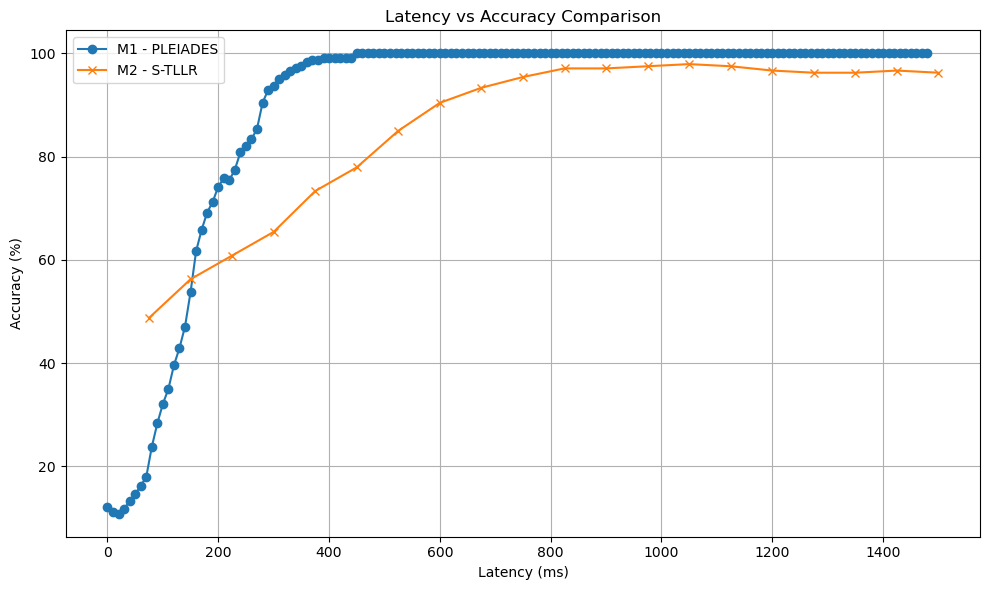

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(m1_latencies_ms, np.array(m1_accuracies) * 100, label='M1 - PLEIADES', marker='o')
plt.plot(m2_latencies_ms, np.array(m2_accuracies) * 100, label='M2 - S-TLLR', marker='x')
plt.title('Latency vs Accuracy Comparison')
plt.xlabel('Latency (ms)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()